The Tile images used in the project were created by Matthias Felleisen and found on his website
https://felleisen.org/matthias/4500-f19/tiles.html

1. Filename: Tsuro(Reward System Change)
2. Version number: 1
3. Creation date: 4th October 2022
4. Last modification date: 27th April 2023
5. Author’s name: Joseph Henry
6. Purpose of the program: Define a reinforcement learning environment based on the board game Tsuro along with an agent to train using the environment.

In [1]:
!pip install gym
!pip install pygame
!pip install tf_agents==0.15.0
!pip install tensorflow
!pip install matplotlib
!pip install numpy


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gym
import numpy as np
import pygame
import time
import random
from gym import spaces
from gym.envs.registration import register
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

# player piece colors [player1, player2]
colors = ['#FF0000', '#0000FF']

# paths for each tile 1-35
node_combinations = [ 
    [(0,3), (1,5), (2,6), (4,7)], [(0,4), (1,5), (2,6), (3,7)], [(0,3), (1,6), (2,5), (4,7)], [(0,6), (1,5), (2,4), (3,7)],
    [(0,1), (2,3), (4,5), (6,7)], [(0,4), (1,5), (2,3), (6,7)], [(0,6), (1,5), (2,3), (4,7)], [(0,5), (1,4), (2,7), (3,6)],
    [(0,5), (1,4), (2,6), (3,7)], [(0,3), (1,4), (2,5), (6,7)], [(0,6), (1,4), (2,5), (3,7)], [(0,5), (1,4), (2,3), (6,7)],
    [(0,2), (1,3), (4,6), (5,7)], [(0,2), (1,3), (4,5), (6,7)], [(0,5), (1,3), (2,7), (4,6)], [(0,6), (1,3), (2,7), (4,5)],
    [(0,4), (1,3), (2,6), (5,7)], [(0,5), (1,3), (2,6), (4,7)], [(0,4), (1,3), (2,5), (6,7)], [(0,6), (1,3), (2,5), (4,7)],
    [(0,5), (1,3), (2,4), (6,7)], [(0,6), (1,3), (2,4), (5,7)], [(0,3), (1,2), (4,7), (5,6)], [(0,3), (1,2), (4,6), (5,7)],
    [(0,3), (1,2), (4,5), (6,7)], [(0,4), (1,2), (3,7), (5,6)], [(0,5), (1,2), (3,7), (4,6)], [(0,6), (1,2), (3,7), (4,5)],
    [(0,4), (1,2), (3,6), (5,7)], [(0,5), (1,2), (3,6), (4,7)], [(0,4), (1,2), (3,5), (6,7)], [(0,6), (1,2), (3,5), (4,7)],
    [(0,5), (1,2), (3,4), (6,7)], [(0,6), (1,2), (3,4), (5,7)], [(0,7), (1,2), (3,4), (5,6)]
]


In [3]:
# Class modelling the tile cards used within Tsuro
class Tile():
    def __init__(self, tile_num, tile_connections):
        self.tile_num = tile_num
        self.image = pygame.image.load("TsuroImages/" + str(tile_num) + ".png")
        self.image = pygame.transform.scale(self.image, (100, 100))
        self.tile_connections = tile_connections
        self.rotation = 1
    # decide where the player should move to
    def move(self, current_node):
        next_node = 0
        next_player_tile = 0
        for connection in self.tile_connections:
            if current_node in connection:
                n1, n2 = connection
                if n1 == current_node:
                    next_node, next_player_tile, next_x, next_y = self.new_tile_node(n2)
                else:
                    next_node, next_player_tile, next_x, next_y = self.new_tile_node(n1)
                return next_node, next_player_tile, next_x, next_y
        raise Exception("Issue in moving players")
    
    # update number of times rotation should be applied to connections and image
    def rotate_tile(self, rotate):
        self.image = pygame.transform.rotate(self.image, rotate * -90)
        self.tile_connections = [tuple((element + (2 * rotate)) % 8 for element in couple ) for couple in self.tile_connections]
        self.rotation = 1 if (self.rotation + 1 % 4 == 0) else self.rotation + 1
    
    # get the current rotation value of the tile
    def get_rotation(self):
        return self.rotation
    
    # decide which tile and node the player should move to from its current position on this tile
    def new_tile_node(self, current_node):
        next_node = 0
        next_x = 0
        next_y = 0
        next_player_tile = 0
        match current_node:
            case 0:
                next_node = 3
                next_player_tile = -1
                next_x = -1
            case 1:
                next_node = 6
                next_player_tile = -6
                next_y = -1
            case 2:
                next_node = 5
                next_player_tile = -6
                next_y = -1
            case 3:
                next_node = 0
                next_player_tile = 1
                next_x = 1
            case 4:
                next_node = 7
                next_player_tile = 1
                next_x = 1
            case 5:
                next_node = 2
                next_player_tile = 6
                next_y = 1
            case 6:
                next_node = 1
                next_player_tile = 6
                next_y = 1
            case 7:
                next_node = 4
                next_player_tile = -1
                next_x = -1
            case _:
                raise Exception("Issue in tile board")
                
        return next_node, next_player_tile, next_x, next_y
    

In [4]:
# Class to model the board game Tsuro as a reinforcement learning environment.
class TsuroEnv(gym.Env):
    # initialise the environment
    def __init__(self):
        self.screen = None
        self.current_player = 1
        self.num_tiles = 35
        self.tile_board_size = (6, 6)
        self.rotation_board_size = (6, 6)
        self.player_board_size = (36,8)
        self.num_players = 2
        self.tiles = []
        for i in range(self.num_tiles):
            self.tiles.append(Tile(i, node_combinations[i]))
            
        self.remaining_tiles = []
        for i in range(self.num_tiles):
            self.remaining_tiles.append(i)
        random.shuffle(self.remaining_tiles)

        self.remaining_players = []
        for i in range(self.num_players):
            self.remaining_players.append(i+1)
        
        self.player_tiles = []
        for i in range(self.num_players):
            player_tiles = []
            for i in range(3):
                player_tiles.append(self.remaining_tiles.pop())
            self.player_tiles.append(player_tiles)
            
        self.rotation_board = np.zeros(self.rotation_board_size, dtype = int)
        self.tile_board = np.zeros(self.tile_board_size, dtype = int)
        self.player_board = np.zeros(self.player_board_size, dtype = int)

        self.action_space = spaces.Discrete(11)
        self.observation_space = spaces.Box(low=-1, high=140, shape=(327,))
        
    def get_tile_obs(self):
        temp = self.rotation_board.flatten()
        temp1 = self.tile_board.flatten()
        for i in range(35):
            temp[i] = ((temp[i] - 1) * 35) + temp1[i]
        return temp
        
    # Resets the environment to default state
    def reset(self): 
        self.current_player = 1
        self.rotation_board = np.zeros(self.rotation_board_size, dtype = int)
        self.tile_board = np.zeros(self.tile_board_size, dtype = int)
        self.player_board = np.zeros(self.player_board_size, dtype = int)
        
        self.tiles = []
        for i in range(self.num_tiles):
            self.tiles.append(Tile(i, node_combinations[i]))
            
        self.remaining_tiles = []
        for i in range(self.num_tiles):
            self.remaining_tiles.append(i)
        random.shuffle(self.remaining_tiles)
            
        self.remaining_players = []
        for i in range(self.num_players):
            self.remaining_players.append(i+1)
            
        self.player_tiles = []
        for i in range(self.num_players):
            player_tiles = []
            for i in range(3):
                player_tiles.append(self.remaining_tiles.pop())
            self.player_tiles.append(player_tiles)
            
        #########################################
        #TODO: TESTING STUFF TO BE REMOVED LATER#
        #########################################
        for i in range(self.num_players):
            self.player_board[random.randint(0,5)][i+1] = i+1
            
        initial_obs = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))

        return initial_obs
    
    # Makes a move in the game based on inputs from player or AI
    def step(self, action = -2, move = -1):
        if move == -1:
            card, rotate = self.get_card(action)
        else:
            card = move
            rotate = 0
        
        action = self.player_tiles[self.current_player - 1][card]
        
        if action == -1:
            observation = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))
            reward = -1
            done = 0
            return observation, reward, done, {}
            
        # Removes used tile and adds new tile from deck to hand
        self.player_tiles[self.current_player-1].remove(action)
        if len(self.remaining_tiles) > 0:
            self.player_tiles[self.current_player-1].append(self.remaining_tiles.pop())
        else:
            self.player_tiles[self.current_player-1].append(-1)
        
        # Rotates tile (Only used by AI)
        self.tiles[action].rotate_tile(rotate)
        
        reward = 0
        self.place_tile(action+1)
        self.move_players()
        reward = self.reward_function()
        if self.game_is_over():
            done = 1
        else:
            done = 0
        self.current_player = self.next_player()
        observation = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))
        return observation, reward, done, {}
    
    # Decides if the game is over
    def game_is_over(self):
        if len(self.remaining_players) <= 1:
            return True
        return False
    
    # Decides the reward (Only used for AI)
    def reward_function(self):
        if not self.game_is_over():
            return 1
        if self.game_is_over() and self.remaining_players[0] == self.current_player:
            return 5
        return -1
    
    # Places tile in self.tile_board
    def place_tile(self, tile):
        tile_number, node_number = np.where(self.player_board == self.current_player)
        x, y = TsuroEnv.euclidean_division(self, tile_number)
        x = x[0]
        y = y[0]
        self.tile_board[x][y] += tile
        self.rotation_board[x][y] += self.tiles[tile-1].get_rotation()
    
    # Moves player piece in self.player_board
    def move_players(self):
        for player in self.remaining_players:
            tile_number, node_number = np.where(self.player_board == player)
            x, y = TsuroEnv.euclidean_division(self, tile_number)
            x = x[0]
            y = y[0]
            while self.tile_board[x][y] != 0:
                tile = self.tiles[(self.tile_board[x][y])-1]
                next_node, next_player_tile, next_x, next_y = tile.move(node_number)
                self.player_board[tile_number[0]][node_number[0]] = 0
                if ((tile_number[0] % 6 == 0) and ((tile_number[0] + next_player_tile) % 6 == 5)) or (tile_number[0] + next_player_tile < 0) or (tile_number[0] + next_player_tile > 35) or ((tile_number[0] % 6 == 5) and ((tile_number[0] + next_player_tile) % 6 == 0)):
                    self.remaining_players.remove(player)
                    break
                else:
                    self.player_board[tile_number[0] + next_player_tile][next_node] = player
                    x += next_x
                    y += next_y
                    tile_number, node_number = np.where(self.player_board == player)
    
    # Quotient and Remainder
    def euclidean_division(self, x, y = 6):
        return x % y, x // y
    
    # Action (card, rotation) from input
    def get_card(self, x, y = 4):
        return  x // y, x % y

    # Decide whos turn it is
    def next_player(self):
        if len(self.remaining_players) == 0:
            return -1
        if self.current_player not in self.remaining_players:
            for player in self.remaining_players:
                if player > self.current_player:
                    return player
                else:
                    return self.remaining_players[0]
        return self.remaining_players[(self.remaining_players.index(self.current_player) + 1) % len(self.remaining_players)]
        
    # Render the environment
    def render(self, mode):
        screen = pygame.display.set_mode((650, 750))
        screen.fill((255, 255, 255))

        # Draw the game board
        board = pygame.image.load("TsuroImages/board.png")
        board = pygame.transform.scale(board, (600, 600))
        screen.blit(board, (25,25))
        
        # Draw current players hand
        for i in range (len(self.player_tiles[self.current_player-1])):
            tile = self.player_tiles[self.current_player-1][i]
            screen.blit(self.tiles[tile].image, (75 + (i * 200), 635))
        
        # Draw the tiles on the board
        for x in range(self.tile_board_size[0]):
            for y in range(self.tile_board_size[1]):
                val = self.tile_board[x][y]
                if val != 0:
                    tile = self.tiles[val-1]
                    screen.blit(tile.image, (25 + x * 100, 25 + y * 100))
                    
        # Draw the players' pieces on the board
        for i in self.remaining_players:
            tile_number, node_number = np.where(self.player_board == i)
            y_add = 0
            x_add = 0
            y_mult = 0
            x_mult = 0
            
            match node_number[0]:
                case 0:
                    y_add = 35
                case 1:
                    x_add = 35
                case 2:
                    x_add = 70
                case 3:
                    x_add = 100
                    y_add = 35
                case 4:
                    x_add = 100
                    y_add = 70
                case 5:
                    x_add = 70
                    y_add = 100
                case 6:
                    x_add = 35
                    y_add = 100
                case 7:
                     y_add = 70
                case _:
                    raise Exception("Issue in drawing the player board")
                    
            if tile_number[0] != 0:
                x_mult, y_mult = TsuroEnv.euclidean_division(self, tile_number[0])
            
            pygame.draw.circle(screen, colors[i-1], (25 + x_add + (100 * x_mult), 25 + y_add + (100 * y_mult)), 5)
            
        # Draw text to show who won when game is over
        if self.game_is_over() or self.current_player == -1:
            font = pygame.font.Font('freesansbold.ttf', 32)
            text = font.render('Player ' + str(self.current_player) + ' wins', True, '#00FF00')
            textRect = text.get_rect()
            textRect.center = (650 // 2, 750 // 2)
            screen.blit(text, textRect)
            
        pygame.display.update()



In [5]:
# Training hyper parameters
num_iterations = 2500000
initial_collect_steps = 10000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 100
learning_rate = 1e-3
log_interval = 200
num_eval_episodes = 500
eval_interval = 5000

register(
    id='TsuroEnv',
    entry_point=TsuroEnv,
)

env_name = "TsuroEnv"

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

fc_layer_params = (200, 100)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    return tf.keras.layers.Dense(num_units, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'))

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(num_actions, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03), bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
    
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step)
    # commenting out render will make training quicker
    # environment.render("human")
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)
        
train_checkpointer = common.Checkpointer(
    ckpt_dir="CheckpointsRC/",
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step_counter
)

train_checkpointer.initialize_or_restore()

In [6]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

agent.train = common.function(agent.train)

returns = []

with open("CheckpointsRC/returns.txt", "r") as txt:
    for line in txt:
        returns.append(line)
        
for i in range(len(returns)):
    returns[i] = returns[i].strip()
    returns[i] = float(returns[i])


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
# Initial Collection for new agent
'''
collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
'''

'\ncollect_data(train_env, random_policy, replay_buffer, initial_collect_steps)\nagent.train_step_counter.assign(0)\n\navg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)\nreturns = [avg_return]\n'

In [14]:
for _ in range(num_iterations):
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        train_checkpointer.save(train_step_counter)
        with open("CheckpointsRC/returns.txt", "w") as txt:
            for item in returns:
                txt.write(str(item) + "\n")


step = 5995200: loss = 3.721721649169922
step = 5995400: loss = 6.312184810638428
step = 5995600: loss = 5.022398948669434
step = 5995800: loss = 4.478516578674316
step = 5996000: loss = 4.180883884429932
step = 5996200: loss = 4.2305521965026855
step = 5996400: loss = 5.138334274291992
step = 5996600: loss = 3.6939525604248047
step = 5996800: loss = 3.6306064128875732
step = 5997000: loss = 3.5971412658691406
step = 5997200: loss = 4.174731731414795
step = 5997400: loss = 4.5114850997924805
step = 5997600: loss = 5.810895919799805
step = 5997800: loss = 5.222387790679932
step = 5998000: loss = 3.465275764465332
step = 5998200: loss = 4.844621658325195
step = 5998400: loss = 4.796956539154053
step = 5998600: loss = 3.3440072536468506
step = 5998800: loss = 3.5316414833068848
step = 5999000: loss = 3.705691337585449
step = 5999200: loss = 4.416993141174316
step = 5999400: loss = 3.362119436264038
step = 5999600: loss = 4.168577194213867
step = 5999800: loss = 2.947946786880493
step = 60

step = 6033400: loss = 3.0204455852508545
step = 6033600: loss = 4.682749271392822
step = 6033800: loss = 4.286647319793701
step = 6034000: loss = 3.179037094116211
step = 6034200: loss = 3.980088472366333
step = 6034400: loss = 5.350275993347168
step = 6034600: loss = 2.6307873725891113
step = 6034800: loss = 4.6301751136779785
step = 6035000: loss = 4.230648517608643
step = 6035000: Average Return = 3.9519999027252197
step = 6035200: loss = 4.478814125061035
step = 6035400: loss = 3.7849504947662354
step = 6035600: loss = 5.502119541168213
step = 6035800: loss = 4.290049076080322
step = 6036000: loss = 3.9614055156707764
step = 6036200: loss = 6.3939104080200195
step = 6036400: loss = 4.757723331451416
step = 6036600: loss = 3.402456045150757
step = 6036800: loss = 2.862636089324951
step = 6037000: loss = 3.852766275405884
step = 6037200: loss = 4.232696533203125
step = 6037400: loss = 3.723334789276123
step = 6037600: loss = 4.095329284667969
step = 6037800: loss = 2.474951505661010

step = 6071200: loss = 3.505056381225586
step = 6071400: loss = 3.730686664581299
step = 6071600: loss = 3.52492618560791
step = 6071800: loss = 3.7808141708374023
step = 6072000: loss = 3.935399055480957
step = 6072200: loss = 3.4706790447235107
step = 6072400: loss = 4.522358417510986
step = 6072600: loss = 4.097124099731445
step = 6072800: loss = 4.8639817237854
step = 6073000: loss = 3.0832302570343018
step = 6073200: loss = 5.31510066986084
step = 6073400: loss = 3.4694161415100098
step = 6073600: loss = 3.2751500606536865
step = 6073800: loss = 4.318653583526611
step = 6074000: loss = 4.803976535797119
step = 6074200: loss = 4.369735240936279
step = 6074400: loss = 4.61971378326416
step = 6074600: loss = 3.47806453704834
step = 6074800: loss = 3.6978204250335693
step = 6075000: loss = 4.851177215576172
step = 6075000: Average Return = 4.326000213623047
step = 6075200: loss = 4.689241886138916
step = 6075400: loss = 3.8607583045959473
step = 6075600: loss = 3.954085111618042
step 

step = 6109400: loss = 6.095999717712402
step = 6109600: loss = 3.1630334854125977
step = 6109800: loss = 4.015230655670166
step = 6110000: loss = 3.9070937633514404
step = 6110000: Average Return = 3.9200000762939453
step = 6110200: loss = 4.034034252166748
step = 6110400: loss = 3.1396946907043457
step = 6110600: loss = 4.946160793304443
step = 6110800: loss = 3.9266247749328613
step = 6111000: loss = 5.046905517578125
step = 6111200: loss = 4.766762733459473
step = 6111400: loss = 3.555940866470337
step = 6111600: loss = 4.475552082061768
step = 6111800: loss = 3.146045207977295
step = 6112000: loss = 4.535886287689209
step = 6112200: loss = 3.8046891689300537
step = 6112400: loss = 4.265984058380127
step = 6112600: loss = 4.277393817901611
step = 6112800: loss = 2.769303321838379
step = 6113000: loss = 4.331012725830078
step = 6113200: loss = 4.2993927001953125
step = 6113400: loss = 4.032430171966553
step = 6113600: loss = 3.8072171211242676
step = 6113800: loss = 3.60255861282348

step = 6147200: loss = 3.7882308959960938
step = 6147400: loss = 3.4762938022613525
step = 6147600: loss = 2.851142406463623
step = 6147800: loss = 4.737337589263916
step = 6148000: loss = 4.691783905029297
step = 6148200: loss = 3.54872727394104
step = 6148400: loss = 2.616689920425415
step = 6148600: loss = 5.075680732727051
step = 6148800: loss = 4.230382442474365
step = 6149000: loss = 3.9145946502685547
step = 6149200: loss = 4.257208824157715
step = 6149400: loss = 4.189011096954346
step = 6149600: loss = 4.366143226623535
step = 6149800: loss = 4.437445163726807
step = 6150000: loss = 4.219913005828857
step = 6150000: Average Return = 4.064000129699707
step = 6150200: loss = 3.6166038513183594
step = 6150400: loss = 4.0168609619140625
step = 6150600: loss = 4.515202045440674
step = 6150800: loss = 2.6233022212982178
step = 6151000: loss = 3.86222505569458
step = 6151200: loss = 4.410624980926514
step = 6151400: loss = 2.8492062091827393
step = 6151600: loss = 4.238287448883057
s

step = 6185000: Average Return = 3.822000026702881
step = 6185200: loss = 4.381800651550293
step = 6185400: loss = 3.2077722549438477
step = 6185600: loss = 4.435975551605225
step = 6185800: loss = 4.404715061187744
step = 6186000: loss = 4.813523769378662
step = 6186200: loss = 4.074595928192139
step = 6186400: loss = 3.5639123916625977
step = 6186600: loss = 4.3239593505859375
step = 6186800: loss = 5.735819339752197
step = 6187000: loss = 4.2806243896484375
step = 6187200: loss = 5.922889709472656
step = 6187400: loss = 3.868511199951172
step = 6187600: loss = 3.3857061862945557
step = 6187800: loss = 4.715109348297119
step = 6188000: loss = 3.9471511840820312
step = 6188200: loss = 4.003030776977539
step = 6188400: loss = 4.39981746673584
step = 6188600: loss = 5.009470462799072
step = 6188800: loss = 3.2074944972991943
step = 6189000: loss = 5.369207859039307
step = 6189200: loss = 3.0961668491363525
step = 6189400: loss = 4.126514911651611
step = 6189600: loss = 4.979984760284424

step = 6223000: loss = 3.6317787170410156
step = 6223200: loss = 3.8003783226013184
step = 6223400: loss = 3.2641148567199707
step = 6223600: loss = 4.093437194824219
step = 6223800: loss = 4.281886577606201
step = 6224000: loss = 4.49216890335083
step = 6224200: loss = 4.278599739074707
step = 6224400: loss = 3.9166688919067383
step = 6224600: loss = 5.075018405914307
step = 6224800: loss = 4.07886266708374
step = 6225000: loss = 4.484333515167236
step = 6225000: Average Return = 3.9179999828338623
step = 6225200: loss = 4.199531078338623
step = 6225400: loss = 4.475429058074951
step = 6225600: loss = 4.196878910064697
step = 6225800: loss = 4.788882732391357
step = 6226000: loss = 3.434483051300049
step = 6226200: loss = 4.475122451782227
step = 6226400: loss = 5.08296537399292
step = 6226600: loss = 2.912235736846924
step = 6226800: loss = 4.406641960144043
step = 6227000: loss = 3.123901605606079
step = 6227200: loss = 4.011288166046143
step = 6227400: loss = 3.3588969707489014
ste

step = 6260800: loss = 4.295735836029053
step = 6261000: loss = 4.876925468444824
step = 6261200: loss = 3.6209962368011475
step = 6261400: loss = 4.658938884735107
step = 6261600: loss = 4.164857387542725
step = 6261800: loss = 4.733813285827637
step = 6262000: loss = 5.123694896697998
step = 6262200: loss = 2.715405225753784
step = 6262400: loss = 4.9581074714660645
step = 6262600: loss = 4.791682243347168
step = 6262800: loss = 5.1056928634643555
step = 6263000: loss = 5.501023292541504
step = 6263200: loss = 4.376328945159912
step = 6263400: loss = 3.0468640327453613
step = 6263600: loss = 5.301736354827881
step = 6263800: loss = 3.3312861919403076
step = 6264000: loss = 4.082496166229248
step = 6264200: loss = 3.905069589614868
step = 6264400: loss = 4.2824296951293945
step = 6264600: loss = 5.25587272644043
step = 6264800: loss = 4.602818489074707
step = 6265000: loss = 3.8704164028167725
step = 6265000: Average Return = 3.8399999141693115
step = 6265200: loss = 5.042802333831787

step = 6299000: loss = 4.275912761688232
step = 6299200: loss = 3.5583183765411377
step = 6299400: loss = 4.483878135681152
step = 6299600: loss = 4.400668621063232
step = 6299800: loss = 4.370092391967773
step = 6300000: loss = 3.802656888961792
step = 6300000: Average Return = 3.6059999465942383
step = 6300200: loss = 4.153077602386475
step = 6300400: loss = 2.4837868213653564
step = 6300600: loss = 3.575190305709839
step = 6300800: loss = 4.576803207397461
step = 6301000: loss = 4.884060382843018
step = 6301200: loss = 5.2165350914001465
step = 6301400: loss = 4.259921073913574
step = 6301600: loss = 5.683173656463623
step = 6301800: loss = 5.029433727264404
step = 6302000: loss = 5.082563877105713
step = 6302200: loss = 4.365467548370361
step = 6302400: loss = 3.893674850463867
step = 6302600: loss = 3.710177421569824
step = 6302800: loss = 4.432351589202881
step = 6303000: loss = 5.351052761077881
step = 6303200: loss = 3.7062861919403076
step = 6303400: loss = 5.298157691955566
s

step = 6337000: loss = 3.5730738639831543
step = 6337200: loss = 3.1603190898895264
step = 6337400: loss = 4.736087799072266
step = 6337600: loss = 4.168814182281494
step = 6337800: loss = 3.554689884185791
step = 6338000: loss = 5.198655128479004
step = 6338200: loss = 4.198616027832031
step = 6338400: loss = 4.830876350402832
step = 6338600: loss = 4.9605865478515625
step = 6338800: loss = 5.005278587341309
step = 6339000: loss = 6.41942024230957
step = 6339200: loss = 4.447668552398682
step = 6339400: loss = 4.434942245483398
step = 6339600: loss = 4.0697526931762695
step = 6339800: loss = 4.699546813964844
step = 6340000: loss = 3.945263624191284
step = 6340000: Average Return = 3.8440001010894775
step = 6340200: loss = 5.644725322723389
step = 6340400: loss = 5.279757499694824
step = 6340600: loss = 4.325854778289795
step = 6340800: loss = 4.530282974243164
step = 6341000: loss = 4.474656581878662
step = 6341200: loss = 4.057031631469727
step = 6341400: loss = 6.2584710121154785
s

step = 6375000: Average Return = 4.035999774932861
step = 6375200: loss = 3.6994705200195312
step = 6375400: loss = 3.0986571311950684
step = 6375600: loss = 5.169196605682373
step = 6375800: loss = 5.197405815124512
step = 6376000: loss = 4.263162612915039
step = 6376200: loss = 3.5512588024139404
step = 6376400: loss = 3.561013698577881
step = 6376600: loss = 3.176813840866089
step = 6376800: loss = 2.9925954341888428
step = 6377000: loss = 5.741820335388184
step = 6377200: loss = 4.790419101715088
step = 6377400: loss = 4.27808141708374
step = 6377600: loss = 5.566009521484375
step = 6377800: loss = 3.6396567821502686
step = 6378000: loss = 2.978137731552124
step = 6378200: loss = 3.1940407752990723
step = 6378400: loss = 3.565073251724243
step = 6378600: loss = 5.38675594329834
step = 6378800: loss = 5.236226558685303
step = 6379000: loss = 3.5323503017425537
step = 6379200: loss = 3.1611921787261963
step = 6379400: loss = 4.754302501678467
step = 6379600: loss = 3.8144946098327637

step = 6413000: loss = 4.193041801452637
step = 6413200: loss = 4.85526180267334
step = 6413400: loss = 4.43080472946167
step = 6413600: loss = 4.883271217346191
step = 6413800: loss = 3.9211065769195557
step = 6414000: loss = 5.7736663818359375
step = 6414200: loss = 5.980485916137695
step = 6414400: loss = 4.227238178253174
step = 6414600: loss = 2.6330578327178955
step = 6414800: loss = 4.045502185821533
step = 6415000: loss = 3.573157548904419
step = 6415000: Average Return = 3.890000104904175
step = 6415200: loss = 4.245012283325195
step = 6415400: loss = 4.203125
step = 6415600: loss = 4.189751625061035
step = 6415800: loss = 5.094022274017334
step = 6416000: loss = 4.074767589569092
step = 6416200: loss = 3.435704231262207
step = 6416400: loss = 5.07464599609375
step = 6416600: loss = 6.174068927764893
step = 6416800: loss = 4.706142902374268
step = 6417000: loss = 3.517591714859009
step = 6417200: loss = 3.7838780879974365
step = 6417400: loss = 3.175023078918457
step = 6417600

step = 6451000: loss = 4.3178815841674805
step = 6451200: loss = 4.137399196624756
step = 6451400: loss = 4.352545261383057
step = 6451600: loss = 4.068772315979004
step = 6451800: loss = 6.293587684631348
step = 6452000: loss = 4.320467948913574
step = 6452200: loss = 3.635545492172241
step = 6452400: loss = 3.222691535949707
step = 6452600: loss = 4.6850762367248535
step = 6452800: loss = 3.747573137283325
step = 6453000: loss = 3.2213759422302246
step = 6453200: loss = 4.995697975158691
step = 6453400: loss = 2.926067352294922
step = 6453600: loss = 3.153981924057007
step = 6453800: loss = 3.7204344272613525
step = 6454000: loss = 4.086048126220703
step = 6454200: loss = 4.28043794631958
step = 6454400: loss = 5.707631587982178
step = 6454600: loss = 3.892730712890625
step = 6454800: loss = 3.8281939029693604
step = 6455000: loss = 4.114816665649414
step = 6455000: Average Return = 3.7239999771118164
step = 6455200: loss = 5.249595642089844
step = 6455400: loss = 4.647380352020264
s

step = 6489200: loss = 4.147768020629883
step = 6489400: loss = 3.943176746368408
step = 6489600: loss = 3.900334358215332
step = 6489800: loss = 4.428408145904541
step = 6490000: loss = 3.9332847595214844
step = 6490000: Average Return = 3.7360000610351562
step = 6490200: loss = 4.7483086585998535
step = 6490400: loss = 3.506763219833374
step = 6490600: loss = 4.565006732940674
step = 6490800: loss = 5.365999698638916
step = 6491000: loss = 4.45745849609375
step = 6491200: loss = 4.2075982093811035
step = 6491400: loss = 5.202545166015625
step = 6491600: loss = 4.906794548034668
step = 6491800: loss = 3.8281147480010986
step = 6492000: loss = 4.770329475402832
step = 6492200: loss = 4.967592239379883
step = 6492400: loss = 5.36158561706543
step = 6492600: loss = 5.00773811340332
step = 6492800: loss = 4.397641658782959
step = 6493000: loss = 4.266026973724365
step = 6493200: loss = 3.478847026824951
step = 6493400: loss = 4.888721466064453
step = 6493600: loss = 4.338351249694824
step

step = 6527000: loss = 4.8645782470703125
step = 6527200: loss = 3.5452258586883545
step = 6527400: loss = 4.615321636199951
step = 6527600: loss = 4.948537349700928
step = 6527800: loss = 4.32551908493042
step = 6528000: loss = 4.886528015136719
step = 6528200: loss = 4.63851261138916
step = 6528400: loss = 3.8299920558929443
step = 6528600: loss = 3.597468852996826
step = 6528800: loss = 4.0600996017456055
step = 6529000: loss = 5.513290882110596
step = 6529200: loss = 3.543076753616333
step = 6529400: loss = 4.945545673370361
step = 6529600: loss = 3.567877769470215
step = 6529800: loss = 5.946383476257324
step = 6530000: loss = 5.836992263793945
step = 6530000: Average Return = 3.4100000858306885
step = 6530200: loss = 4.548415660858154
step = 6530400: loss = 2.7940917015075684
step = 6530600: loss = 2.9052717685699463
step = 6530800: loss = 4.980656623840332
step = 6531000: loss = 2.001068592071533
step = 6531200: loss = 4.186161994934082
step = 6531400: loss = 4.664988994598389
s

step = 6565000: Average Return = 3.4519999027252197
step = 6565200: loss = 4.320460796356201
step = 6565400: loss = 3.732633590698242
step = 6565600: loss = 3.9168803691864014
step = 6565800: loss = 2.784533977508545
step = 6566000: loss = 4.605435848236084
step = 6566200: loss = 4.990578651428223
step = 6566400: loss = 3.621657609939575
step = 6566600: loss = 3.6860644817352295
step = 6566800: loss = 3.861980438232422
step = 6567000: loss = 5.158178806304932
step = 6567200: loss = 4.892251968383789
step = 6567400: loss = 3.9040772914886475
step = 6567600: loss = 2.4648537635803223
step = 6567800: loss = 2.9448375701904297
step = 6568000: loss = 3.9369328022003174
step = 6568200: loss = 3.7475101947784424
step = 6568400: loss = 4.749974727630615
step = 6568600: loss = 4.684539794921875
step = 6568800: loss = 4.23379373550415
step = 6569000: loss = 4.439396381378174
step = 6569200: loss = 4.4115986824035645
step = 6569400: loss = 4.5450944900512695
step = 6569600: loss = 4.9355964660644

step = 6603200: loss = 5.499673843383789
step = 6603400: loss = 2.8945956230163574
step = 6603600: loss = 3.678081512451172
step = 6603800: loss = 5.124454975128174
step = 6604000: loss = 3.7913830280303955
step = 6604200: loss = 4.123239517211914
step = 6604400: loss = 3.227091073989868
step = 6604600: loss = 3.9728939533233643
step = 6604800: loss = 4.570633411407471
step = 6605000: loss = 3.5396313667297363
step = 6605000: Average Return = 4.064000129699707
step = 6605200: loss = 4.549286842346191
step = 6605400: loss = 3.454767942428589
step = 6605600: loss = 4.166843414306641
step = 6605800: loss = 4.327101230621338
step = 6606000: loss = 3.2899038791656494
step = 6606200: loss = 4.2456183433532715
step = 6606400: loss = 4.738654613494873
step = 6606600: loss = 4.13352108001709
step = 6606800: loss = 4.513794898986816
step = 6607000: loss = 4.896460056304932
step = 6607200: loss = 4.314357757568359
step = 6607400: loss = 4.519502639770508
step = 6607600: loss = 4.341879367828369
s

step = 6641000: loss = 3.3256616592407227
step = 6641200: loss = 4.557293891906738
step = 6641400: loss = 3.8383610248565674
step = 6641600: loss = 3.9477782249450684
step = 6641800: loss = 5.310168266296387
step = 6642000: loss = 3.6865346431732178
step = 6642200: loss = 4.687551975250244
step = 6642400: loss = 3.176372528076172
step = 6642600: loss = 4.263217449188232
step = 6642800: loss = 4.014604568481445
step = 6643000: loss = 3.1247735023498535
step = 6643200: loss = 4.295222759246826
step = 6643400: loss = 3.76226544380188
step = 6643600: loss = 3.6649465560913086
step = 6643800: loss = 4.533857822418213
step = 6644000: loss = 4.314009189605713
step = 6644200: loss = 3.53237247467041
step = 6644400: loss = 4.417401313781738
step = 6644600: loss = 3.296210289001465
step = 6644800: loss = 4.364664077758789
step = 6645000: loss = 4.037410736083984
step = 6645000: Average Return = 3.065999984741211
step = 6645200: loss = 3.232034921646118
step = 6645400: loss = 4.579688549041748
st

step = 6679200: loss = 4.227924823760986
step = 6679400: loss = 4.490689754486084
step = 6679600: loss = 4.520518779754639
step = 6679800: loss = 3.434213876724243
step = 6680000: loss = 3.953568935394287
step = 6680000: Average Return = 3.7839999198913574
step = 6680200: loss = 4.331204891204834
step = 6680400: loss = 4.195681095123291
step = 6680600: loss = 4.431516647338867
step = 6680800: loss = 3.1728670597076416
step = 6681000: loss = 5.0264973640441895
step = 6681200: loss = 5.146361351013184
step = 6681400: loss = 6.056111812591553
step = 6681600: loss = 5.39654541015625
step = 6681800: loss = 4.353381633758545
step = 6682000: loss = 6.021529197692871
step = 6682200: loss = 5.531642913818359
step = 6682400: loss = 3.0255656242370605
step = 6682600: loss = 3.368089199066162
step = 6682800: loss = 4.4760308265686035
step = 6683000: loss = 5.224592208862305
step = 6683200: loss = 3.1763973236083984
step = 6683400: loss = 5.368862152099609
step = 6683600: loss = 4.797026634216309
s

step = 6717200: loss = 5.60240364074707
step = 6717400: loss = 4.490548133850098
step = 6717600: loss = 4.165299415588379
step = 6717800: loss = 3.7055580615997314
step = 6718000: loss = 5.211522579193115
step = 6718200: loss = 3.7193069458007812
step = 6718400: loss = 5.675292015075684
step = 6718600: loss = 4.6113176345825195
step = 6718800: loss = 4.389528274536133
step = 6719000: loss = 3.4072210788726807
step = 6719200: loss = 4.160015106201172
step = 6719400: loss = 3.608738899230957
step = 6719600: loss = 4.140509128570557
step = 6719800: loss = 3.7964513301849365
step = 6720000: loss = 4.2476372718811035
step = 6720000: Average Return = 3.131999969482422
step = 6720200: loss = 3.4993464946746826
step = 6720400: loss = 3.1946141719818115
step = 6720600: loss = 3.511310338973999
step = 6720800: loss = 4.834535121917725
step = 6721000: loss = 5.050051689147949
step = 6721200: loss = 3.148991107940674
step = 6721400: loss = 4.902029037475586
step = 6721600: loss = 4.603137493133545

step = 6755200: loss = 4.680232524871826
step = 6755400: loss = 4.3280930519104
step = 6755600: loss = 4.425404071807861
step = 6755800: loss = 4.679055213928223
step = 6756000: loss = 4.165393829345703
step = 6756200: loss = 3.5718705654144287
step = 6756400: loss = 4.49406099319458
step = 6756600: loss = 3.5939013957977295
step = 6756800: loss = 4.26520299911499
step = 6757000: loss = 5.105963706970215
step = 6757200: loss = 3.31447434425354
step = 6757400: loss = 5.421731472015381
step = 6757600: loss = 4.112637996673584
step = 6757800: loss = 3.38515305519104
step = 6758000: loss = 6.086679458618164
step = 6758200: loss = 4.161956787109375
step = 6758400: loss = 2.9553654193878174
step = 6758600: loss = 4.00858211517334
step = 6758800: loss = 4.845098972320557
step = 6759000: loss = 4.6995720863342285
step = 6759200: loss = 5.639697551727295
step = 6759400: loss = 4.255546569824219
step = 6759600: loss = 5.493049144744873
step = 6759800: loss = 4.327101230621338
step = 6760000: los

step = 6793400: loss = 3.3823726177215576
step = 6793600: loss = 3.3385140895843506
step = 6793800: loss = 4.428542613983154
step = 6794000: loss = 4.246138095855713
step = 6794200: loss = 4.64415168762207
step = 6794400: loss = 3.0965864658355713
step = 6794600: loss = 4.490485668182373
step = 6794800: loss = 3.963782548904419
step = 6795000: loss = 2.8476223945617676
step = 6795000: Average Return = 3.6440000534057617
step = 6795200: loss = 4.585873126983643
step = 6795400: loss = 4.533801078796387
step = 6795600: loss = 3.7386107444763184
step = 6795800: loss = 3.237401247024536
step = 6796000: loss = 3.5070457458496094
step = 6796200: loss = 4.515280246734619
step = 6796400: loss = 4.779436111450195
step = 6796600: loss = 4.597762107849121
step = 6796800: loss = 3.2416484355926514
step = 6797000: loss = 3.8679583072662354
step = 6797200: loss = 4.621822834014893
step = 6797400: loss = 4.490955352783203
step = 6797600: loss = 5.411374568939209
step = 6797800: loss = 4.79422330856323

step = 6831200: loss = 5.000812530517578
step = 6831400: loss = 4.844035625457764
step = 6831600: loss = 3.9187614917755127
step = 6831800: loss = 5.5015153884887695
step = 6832000: loss = 4.1682610511779785
step = 6832200: loss = 3.0862996578216553
step = 6832400: loss = 4.355040550231934
step = 6832600: loss = 3.697665214538574
step = 6832800: loss = 4.287742614746094
step = 6833000: loss = 5.041090488433838
step = 6833200: loss = 4.151019096374512
step = 6833400: loss = 5.2527618408203125
step = 6833600: loss = 2.857957601547241
step = 6833800: loss = 3.934495210647583
step = 6834000: loss = 4.401918411254883
step = 6834200: loss = 3.417694568634033
step = 6834400: loss = 5.576544761657715
step = 6834600: loss = 4.788842678070068
step = 6834800: loss = 4.334284782409668
step = 6835000: loss = 5.561241149902344
step = 6835000: Average Return = 3.5460000038146973
step = 6835200: loss = 5.034045696258545
step = 6835400: loss = 5.705831050872803
step = 6835600: loss = 4.246219158172607


step = 6869400: loss = 5.268792152404785
step = 6869600: loss = 5.368092060089111
step = 6869800: loss = 4.389887809753418
step = 6870000: loss = 5.395503997802734
step = 6870000: Average Return = 3.799999952316284
step = 6870200: loss = 3.0682497024536133
step = 6870400: loss = 4.901968955993652
step = 6870600: loss = 2.6546175479888916
step = 6870800: loss = 5.569167137145996
step = 6871000: loss = 5.294205188751221
step = 6871200: loss = 5.186280250549316
step = 6871400: loss = 4.216839790344238
step = 6871600: loss = 4.4672770500183105
step = 6871800: loss = 5.560649871826172
step = 6872000: loss = 4.515106678009033
step = 6872200: loss = 4.376273155212402
step = 6872400: loss = 3.467550039291382
step = 6872600: loss = 4.5829176902771
step = 6872800: loss = 2.836230516433716
step = 6873000: loss = 4.302285194396973
step = 6873200: loss = 3.6106603145599365
step = 6873400: loss = 4.275452613830566
step = 6873600: loss = 4.007187843322754
step = 6873800: loss = 3.396845817565918
step

step = 6907200: loss = 5.008524417877197
step = 6907400: loss = 4.471097469329834
step = 6907600: loss = 5.599893569946289
step = 6907800: loss = 5.082119464874268
step = 6908000: loss = 4.500255107879639
step = 6908200: loss = 3.542991876602173
step = 6908400: loss = 4.46883487701416
step = 6908600: loss = 4.021073341369629
step = 6908800: loss = 3.6033031940460205
step = 6909000: loss = 3.981748580932617
step = 6909200: loss = 2.834782600402832
step = 6909400: loss = 4.7064690589904785
step = 6909600: loss = 3.56791615486145
step = 6909800: loss = 4.228169918060303
step = 6910000: loss = 4.311771869659424
step = 6910000: Average Return = 3.569999933242798
step = 6910200: loss = 2.7220587730407715
step = 6910400: loss = 4.086409091949463
step = 6910600: loss = 4.074497699737549
step = 6910800: loss = 4.770052433013916
step = 6911000: loss = 4.134711742401123
step = 6911200: loss = 4.574396133422852
step = 6911400: loss = 4.513888835906982
step = 6911600: loss = 3.8353826999664307
step

step = 6945000: Average Return = 4.050000190734863
step = 6945200: loss = 3.7329680919647217
step = 6945400: loss = 4.426027297973633
step = 6945600: loss = 4.130068302154541
step = 6945800: loss = 3.28641414642334
step = 6946000: loss = 3.9165499210357666
step = 6946200: loss = 3.8909149169921875
step = 6946400: loss = 5.52581787109375
step = 6946600: loss = 4.109249114990234
step = 6946800: loss = 3.2417094707489014
step = 6947000: loss = 3.5770390033721924
step = 6947200: loss = 4.141136169433594
step = 6947400: loss = 3.0162453651428223
step = 6947600: loss = 5.05057954788208
step = 6947800: loss = 4.128719806671143
step = 6948000: loss = 4.848967552185059
step = 6948200: loss = 4.734541416168213
step = 6948400: loss = 3.5972986221313477
step = 6948600: loss = 3.7345149517059326
step = 6948800: loss = 4.5240936279296875
step = 6949000: loss = 3.596797466278076
step = 6949200: loss = 4.244327068328857
step = 6949400: loss = 3.1099889278411865
step = 6949600: loss = 3.692105054855346

step = 6983000: loss = 3.358060121536255
step = 6983200: loss = 4.478181838989258
step = 6983400: loss = 3.891979932785034
step = 6983600: loss = 3.522662878036499
step = 6983800: loss = 4.368640422821045
step = 6984000: loss = 3.9789793491363525
step = 6984200: loss = 4.17987585067749
step = 6984400: loss = 5.200779914855957
step = 6984600: loss = 5.850362300872803
step = 6984800: loss = 4.373265266418457
step = 6985000: loss = 3.204685688018799
step = 6985000: Average Return = 3.7660000324249268
step = 6985200: loss = 4.4768242835998535
step = 6985400: loss = 4.3160834312438965
step = 6985600: loss = 3.4197356700897217
step = 6985800: loss = 5.102095603942871
step = 6986000: loss = 4.196985244750977
step = 6986200: loss = 4.288804531097412
step = 6986400: loss = 4.795173645019531
step = 6986600: loss = 3.5070159435272217
step = 6986800: loss = 3.5564491748809814
step = 6987000: loss = 4.388482570648193
step = 6987200: loss = 3.422914981842041
step = 6987400: loss = 4.9982709884643555

step = 7020800: loss = 2.8810439109802246
step = 7021000: loss = 4.758373737335205
step = 7021200: loss = 3.9060182571411133
step = 7021400: loss = 3.941267967224121
step = 7021600: loss = 5.154537677764893
step = 7021800: loss = 4.208099842071533
step = 7022000: loss = 4.2696990966796875
step = 7022200: loss = 3.883169412612915
step = 7022400: loss = 4.565516471862793
step = 7022600: loss = 4.207765579223633
step = 7022800: loss = 4.514678478240967
step = 7023000: loss = 5.34979772567749
step = 7023200: loss = 4.035694599151611
step = 7023400: loss = 2.909904718399048
step = 7023600: loss = 3.7734673023223877
step = 7023800: loss = 5.451479434967041
step = 7024000: loss = 3.788991928100586
step = 7024200: loss = 4.129766464233398
step = 7024400: loss = 4.360753536224365
step = 7024600: loss = 3.380476951599121
step = 7024800: loss = 3.9702131748199463
step = 7025000: loss = 3.737095832824707
step = 7025000: Average Return = 4.216000080108643
step = 7025200: loss = 3.6382317543029785
s

step = 7059000: loss = 4.215341567993164
step = 7059200: loss = 4.8263139724731445
step = 7059400: loss = 4.1905622482299805
step = 7059600: loss = 4.4847941398620605
step = 7059800: loss = 4.764014720916748
step = 7060000: loss = 3.105435609817505
step = 7060000: Average Return = 4.406000137329102
step = 7060200: loss = 3.257366895675659
step = 7060400: loss = 3.6868739128112793
step = 7060600: loss = 4.729396343231201
step = 7060800: loss = 4.640610218048096
step = 7061000: loss = 3.8937437534332275
step = 7061200: loss = 4.791386604309082
step = 7061400: loss = 2.9002575874328613
step = 7061600: loss = 3.758146286010742
step = 7061800: loss = 4.792892932891846
step = 7062000: loss = 3.901418924331665
step = 7062200: loss = 3.4807896614074707
step = 7062400: loss = 3.455416202545166
step = 7062600: loss = 2.4458870887756348
step = 7062800: loss = 4.098262310028076
step = 7063000: loss = 5.40174674987793
step = 7063200: loss = 2.919224262237549
step = 7063400: loss = 4.702253341674805

step = 7096800: loss = 4.654162406921387
step = 7097000: loss = 5.185159683227539
step = 7097200: loss = 5.064602851867676
step = 7097400: loss = 2.6275668144226074
step = 7097600: loss = 3.2948405742645264
step = 7097800: loss = 6.215354919433594
step = 7098000: loss = 3.3229711055755615
step = 7098200: loss = 4.505946159362793
step = 7098400: loss = 3.868083953857422
step = 7098600: loss = 4.090545654296875
step = 7098800: loss = 2.88731050491333
step = 7099000: loss = 4.337634086608887
step = 7099200: loss = 4.238895893096924
step = 7099400: loss = 5.781961917877197
step = 7099600: loss = 4.453878879547119
step = 7099800: loss = 3.3342905044555664
step = 7100000: loss = 4.129609107971191
step = 7100000: Average Return = 3.4539999961853027
step = 7100200: loss = 3.704427480697632
step = 7100400: loss = 5.145837306976318
step = 7100600: loss = 3.4978747367858887
step = 7100800: loss = 4.469105243682861
step = 7101000: loss = 4.563694477081299
step = 7101200: loss = 4.851559162139893
s

step = 7134800: loss = 5.1733269691467285
step = 7135000: loss = 6.398867130279541
step = 7135000: Average Return = 4.119999885559082
step = 7135200: loss = 3.145603656768799
step = 7135400: loss = 4.910528659820557
step = 7135600: loss = 3.285592794418335
step = 7135800: loss = 3.6127166748046875
step = 7136000: loss = 4.6729044914245605
step = 7136200: loss = 4.298862934112549
step = 7136400: loss = 4.9162397384643555
step = 7136600: loss = 4.4642181396484375
step = 7136800: loss = 3.8015129566192627
step = 7137000: loss = 3.8984739780426025
step = 7137200: loss = 4.907519340515137
step = 7137400: loss = 4.269600868225098
step = 7137600: loss = 4.173521518707275
step = 7137800: loss = 2.4046900272369385
step = 7138000: loss = 3.5695323944091797
step = 7138200: loss = 3.9977564811706543
step = 7138400: loss = 2.9086620807647705
step = 7138600: loss = 5.090811729431152
step = 7138800: loss = 3.6390745639801025
step = 7139000: loss = 3.9165496826171875
step = 7139200: loss = 4.192847251

step = 7172600: loss = 5.090634346008301
step = 7172800: loss = 4.168609619140625
step = 7173000: loss = 4.70703649520874
step = 7173200: loss = 4.755272388458252
step = 7173400: loss = 4.168472766876221
step = 7173600: loss = 3.881523370742798
step = 7173800: loss = 5.719793796539307
step = 7174000: loss = 3.9296038150787354
step = 7174200: loss = 4.041571140289307
step = 7174400: loss = 4.21513032913208
step = 7174600: loss = 4.693690299987793
step = 7174800: loss = 3.2579565048217773
step = 7175000: loss = 3.3997740745544434
step = 7175000: Average Return = 3.619999885559082
step = 7175200: loss = 4.53959846496582
step = 7175400: loss = 2.4333925247192383
step = 7175600: loss = 4.704176425933838
step = 7175800: loss = 3.8587987422943115
step = 7176000: loss = 4.504924774169922
step = 7176200: loss = 3.3480653762817383
step = 7176400: loss = 4.020325183868408
step = 7176600: loss = 3.743381977081299
step = 7176800: loss = 3.0447349548339844
step = 7177000: loss = 4.060785293579102
st

step = 7210600: loss = 5.3684515953063965
step = 7210800: loss = 3.9266891479492188
step = 7211000: loss = 1.755560278892517
step = 7211200: loss = 4.284847736358643
step = 7211400: loss = 4.49729585647583
step = 7211600: loss = 4.614400386810303
step = 7211800: loss = 4.005825042724609
step = 7212000: loss = 4.282187461853027
step = 7212200: loss = 3.6829609870910645
step = 7212400: loss = 4.2693915367126465
step = 7212600: loss = 5.387907028198242
step = 7212800: loss = 4.768205642700195
step = 7213000: loss = 3.4505083560943604
step = 7213200: loss = 3.7996294498443604
step = 7213400: loss = 4.11665678024292
step = 7213600: loss = 5.704102516174316
step = 7213800: loss = 4.308841228485107
step = 7214000: loss = 3.8344783782958984
step = 7214200: loss = 4.6983819007873535
step = 7214400: loss = 3.8310062885284424
step = 7214600: loss = 4.60064172744751
step = 7214800: loss = 3.1255252361297607
step = 7215000: loss = 4.634775161743164
step = 7215000: Average Return = 3.638000011444092

step = 7248600: loss = 4.049501419067383
step = 7248800: loss = 4.020728588104248
step = 7249000: loss = 3.0495445728302
step = 7249200: loss = 4.155575275421143
step = 7249400: loss = 3.619490385055542
step = 7249600: loss = 3.1318583488464355
step = 7249800: loss = 4.375550270080566
step = 7250000: loss = 3.1955718994140625
step = 7250000: Average Return = 3.9679999351501465
step = 7250200: loss = 4.743757724761963
step = 7250400: loss = 5.399250507354736
step = 7250600: loss = 4.8735785484313965
step = 7250800: loss = 5.92165994644165
step = 7251000: loss = 2.6979594230651855
step = 7251200: loss = 4.514686107635498
step = 7251400: loss = 2.9655680656433105
step = 7251600: loss = 3.2178893089294434
step = 7251800: loss = 5.78584098815918
step = 7252000: loss = 4.494884967803955
step = 7252200: loss = 3.648378849029541
step = 7252400: loss = 3.941152334213257
step = 7252600: loss = 4.447263240814209
step = 7252800: loss = 3.906331777572632
step = 7253000: loss = 3.8768749237060547
st

step = 7286400: loss = 4.557530879974365
step = 7286600: loss = 4.994898796081543
step = 7286800: loss = 4.043516159057617
step = 7287000: loss = 3.4445128440856934
step = 7287200: loss = 3.4117205142974854
step = 7287400: loss = 4.634140968322754
step = 7287600: loss = 3.6141197681427
step = 7287800: loss = 4.524899005889893
step = 7288000: loss = 3.8877716064453125
step = 7288200: loss = 3.5896360874176025
step = 7288400: loss = 3.631503105163574
step = 7288600: loss = 3.7403526306152344
step = 7288800: loss = 4.015655517578125
step = 7289000: loss = 3.733030319213867
step = 7289200: loss = 4.84677791595459
step = 7289400: loss = 4.200585842132568
step = 7289600: loss = 3.7229058742523193
step = 7289800: loss = 4.4350128173828125
step = 7290000: loss = 4.155377388000488
step = 7290000: Average Return = 4.0320000648498535
step = 7290200: loss = 4.0422797203063965
step = 7290400: loss = 3.296034097671509
step = 7290600: loss = 4.872280597686768
step = 7290800: loss = 4.141878128051758


step = 7324600: loss = 3.0683703422546387
step = 7324800: loss = 3.9279675483703613
step = 7325000: loss = 3.9634742736816406
step = 7325000: Average Return = 3.885999917984009
step = 7325200: loss = 4.459737300872803
step = 7325400: loss = 5.376370906829834
step = 7325600: loss = 4.082558631896973
step = 7325800: loss = 3.2614104747772217
step = 7326000: loss = 2.783093214035034
step = 7326200: loss = 5.494791030883789
step = 7326400: loss = 3.1322057247161865
step = 7326600: loss = 3.806847095489502
step = 7326800: loss = 4.696680068969727
step = 7327000: loss = 6.447519779205322
step = 7327200: loss = 3.7235937118530273
step = 7327400: loss = 3.3606958389282227
step = 7327600: loss = 3.4020042419433594
step = 7327800: loss = 5.709150314331055
step = 7328000: loss = 4.769197940826416
step = 7328200: loss = 4.519984722137451
step = 7328400: loss = 3.595623016357422
step = 7328600: loss = 3.9450371265411377
step = 7328800: loss = 3.1433677673339844
step = 7329000: loss = 4.892395019531

step = 7362400: loss = 3.3155181407928467
step = 7362600: loss = 2.9817497730255127
step = 7362800: loss = 5.772285461425781
step = 7363000: loss = 4.895447254180908
step = 7363200: loss = 4.019271373748779
step = 7363400: loss = 2.631826400756836
step = 7363600: loss = 4.876781463623047
step = 7363800: loss = 4.498683929443359
step = 7364000: loss = 3.7540950775146484
step = 7364200: loss = 4.9364399909973145
step = 7364400: loss = 4.399410724639893
step = 7364600: loss = 4.904702186584473
step = 7364800: loss = 3.999131441116333
step = 7365000: loss = 4.324873447418213
step = 7365000: Average Return = 3.7100000381469727
step = 7365200: loss = 5.747902870178223
step = 7365400: loss = 4.720142364501953
step = 7365600: loss = 4.007038593292236
step = 7365800: loss = 5.240640163421631
step = 7366000: loss = 5.520788669586182
step = 7366200: loss = 3.8466436862945557
step = 7366400: loss = 4.907010555267334
step = 7366600: loss = 3.33111572265625
step = 7366800: loss = 5.133821964263916
s

step = 7400200: loss = 4.447229385375977
step = 7400400: loss = 3.6961352825164795
step = 7400600: loss = 3.371094226837158
step = 7400800: loss = 4.60756778717041
step = 7401000: loss = 4.3692498207092285
step = 7401200: loss = 3.1921279430389404
step = 7401400: loss = 3.1797027587890625
step = 7401600: loss = 5.686399936676025
step = 7401800: loss = 3.9304542541503906
step = 7402000: loss = 4.227971076965332
step = 7402200: loss = 4.150016784667969
step = 7402400: loss = 3.482020139694214
step = 7402600: loss = 4.271517753601074
step = 7402800: loss = 4.278043746948242
step = 7403000: loss = 3.3731706142425537
step = 7403200: loss = 3.8818070888519287
step = 7403400: loss = 4.157451152801514
step = 7403600: loss = 5.518837928771973
step = 7403800: loss = 5.400068759918213
step = 7404000: loss = 4.6734232902526855
step = 7404200: loss = 3.903672695159912
step = 7404400: loss = 4.806600093841553
step = 7404600: loss = 3.9069137573242188
step = 7404800: loss = 5.111972332000732
step = 7

step = 7438200: loss = 3.2994279861450195
step = 7438400: loss = 5.303977012634277
step = 7438600: loss = 4.472548961639404
step = 7438800: loss = 3.968998908996582
step = 7439000: loss = 4.309366703033447
step = 7439200: loss = 4.4383063316345215
step = 7439400: loss = 3.6125786304473877
step = 7439600: loss = 4.301914215087891
step = 7439800: loss = 4.669578552246094
step = 7440000: loss = 5.286014080047607
step = 7440000: Average Return = 3.869999885559082
step = 7440200: loss = 4.066028118133545
step = 7440400: loss = 4.0746917724609375
step = 7440600: loss = 4.128541469573975
step = 7440800: loss = 6.010529041290283
step = 7441000: loss = 3.5529022216796875
step = 7441200: loss = 3.675901412963867
step = 7441400: loss = 4.579920291900635
step = 7441600: loss = 3.754801034927368
step = 7441800: loss = 5.577961444854736
step = 7442000: loss = 2.9558794498443604
step = 7442200: loss = 2.870192289352417
step = 7442400: loss = 4.030210971832275
step = 7442600: loss = 4.116692543029785


step = 7476000: loss = 3.258859872817993
step = 7476200: loss = 3.6666386127471924
step = 7476400: loss = 4.106882095336914
step = 7476600: loss = 3.5139684677124023
step = 7476800: loss = 4.498973369598389
step = 7477000: loss = 4.763489246368408
step = 7477200: loss = 3.6755166053771973
step = 7477400: loss = 3.6784253120422363
step = 7477600: loss = 3.7917888164520264
step = 7477800: loss = 4.008041858673096
step = 7478000: loss = 5.018956184387207
step = 7478200: loss = 3.979076862335205
step = 7478400: loss = 3.7940189838409424
step = 7478600: loss = 3.5819931030273438
step = 7478800: loss = 3.2852602005004883
step = 7479000: loss = 3.9757039546966553
step = 7479200: loss = 3.784860134124756
step = 7479400: loss = 2.393092632293701
step = 7479600: loss = 5.122678756713867
step = 7479800: loss = 4.003669261932373
step = 7480000: loss = 3.844606637954712
step = 7480000: Average Return = 3.742000102996826
step = 7480200: loss = 4.685690879821777
step = 7480400: loss = 4.7614431381225

step = 7514200: loss = 4.709856033325195
step = 7514400: loss = 3.651249408721924
step = 7514600: loss = 4.050919532775879
step = 7514800: loss = 3.827277183532715
step = 7515000: loss = 2.856942653656006
step = 7515000: Average Return = 4.230000019073486
step = 7515200: loss = 3.8804008960723877
step = 7515400: loss = 4.544236183166504
step = 7515600: loss = 3.7098381519317627
step = 7515800: loss = 3.438685894012451
step = 7516000: loss = 5.6759185791015625
step = 7516200: loss = 6.188982963562012
step = 7516400: loss = 4.356800556182861
step = 7516600: loss = 4.044402599334717
step = 7516800: loss = 4.283596515655518
step = 7517000: loss = 3.4487133026123047
step = 7517200: loss = 3.556175470352173
step = 7517400: loss = 4.616389751434326
step = 7517600: loss = 6.057120323181152
step = 7517800: loss = 2.9336202144622803
step = 7518000: loss = 2.9400713443756104
step = 7518200: loss = 4.895273208618164
step = 7518400: loss = 4.250969886779785
step = 7518600: loss = 3.814581871032715


step = 7552000: loss = 4.762892723083496
step = 7552200: loss = 2.8922274112701416
step = 7552400: loss = 4.043050289154053
step = 7552600: loss = 3.6638689041137695
step = 7552800: loss = 2.9714629650115967
step = 7553000: loss = 3.5908684730529785
step = 7553200: loss = 4.18757438659668
step = 7553400: loss = 5.157598972320557
step = 7553600: loss = 4.276816368103027
step = 7553800: loss = 4.313300609588623
step = 7554000: loss = 3.1269469261169434
step = 7554200: loss = 3.9078636169433594
step = 7554400: loss = 2.858846426010132
step = 7554600: loss = 4.213656902313232
step = 7554800: loss = 3.767186164855957
step = 7555000: loss = 4.784791469573975
step = 7555000: Average Return = 3.7119998931884766
step = 7555200: loss = 4.347754001617432
step = 7555400: loss = 3.3414599895477295
step = 7555600: loss = 4.937972068786621
step = 7555800: loss = 3.7630913257598877
step = 7556000: loss = 4.508668899536133
step = 7556200: loss = 4.303723335266113
step = 7556400: loss = 4.34239149093627

step = 7590000: Average Return = 3.874000072479248
step = 7590200: loss = 3.7945187091827393
step = 7590400: loss = 6.407734394073486
step = 7590600: loss = 4.021975040435791
step = 7590800: loss = 4.558872222900391
step = 7591000: loss = 3.9738881587982178
step = 7591200: loss = 3.542562246322632
step = 7591400: loss = 4.876863479614258
step = 7591600: loss = 6.052774906158447
step = 7591800: loss = 4.501041412353516
step = 7592000: loss = 3.66994309425354
step = 7592200: loss = 2.5966246128082275
step = 7592400: loss = 2.8064393997192383
step = 7592600: loss = 3.6653056144714355
step = 7592800: loss = 3.8348939418792725
step = 7593000: loss = 4.431382179260254
step = 7593200: loss = 3.2999870777130127
step = 7593400: loss = 3.9843695163726807
step = 7593600: loss = 3.077613353729248
step = 7593800: loss = 3.775623083114624
step = 7594000: loss = 3.946547746658325
step = 7594200: loss = 4.969974040985107
step = 7594400: loss = 5.530066967010498
step = 7594600: loss = 4.60692024230957


step = 7628200: loss = 5.295083999633789
step = 7628400: loss = 4.460451126098633
step = 7628600: loss = 3.227879047393799
step = 7628800: loss = 4.281043529510498
step = 7629000: loss = 3.81762957572937
step = 7629200: loss = 2.9789798259735107
step = 7629400: loss = 4.210666179656982
step = 7629600: loss = 3.850520133972168
step = 7629800: loss = 6.394344329833984
step = 7630000: loss = 5.359087944030762
step = 7630000: Average Return = 3.940000057220459
step = 7630200: loss = 4.476598262786865
step = 7630400: loss = 4.74662971496582
step = 7630600: loss = 3.963512420654297
step = 7630800: loss = 5.910053730010986
step = 7631000: loss = 5.209101676940918
step = 7631200: loss = 4.245002269744873
step = 7631400: loss = 6.304507732391357
step = 7631600: loss = 5.736163139343262
step = 7631800: loss = 3.1298887729644775
step = 7632000: loss = 2.682898759841919
step = 7632200: loss = 3.725504159927368
step = 7632400: loss = 3.7397375106811523
step = 7632600: loss = 5.793368816375732
step 

step = 7666000: loss = 4.026736736297607
step = 7666200: loss = 2.4610514640808105
step = 7666400: loss = 3.391239643096924
step = 7666600: loss = 3.3449461460113525
step = 7666800: loss = 4.030251979827881
step = 7667000: loss = 4.9322509765625
step = 7667200: loss = 3.804462432861328
step = 7667400: loss = 5.127498626708984
step = 7667600: loss = 3.534379720687866
step = 7667800: loss = 5.5731706619262695
step = 7668000: loss = 3.639846086502075
step = 7668200: loss = 4.189273834228516
step = 7668400: loss = 3.1039276123046875
step = 7668600: loss = 5.876523494720459
step = 7668800: loss = 4.256253719329834
step = 7669000: loss = 2.1683902740478516
step = 7669200: loss = 3.24960994720459
step = 7669400: loss = 3.5918283462524414
step = 7669600: loss = 4.099466323852539
step = 7669800: loss = 4.366819381713867
step = 7670000: loss = 2.731132745742798
step = 7670000: Average Return = 4.085999965667725
step = 7670200: loss = 4.253963470458984
step = 7670400: loss = 4.933370113372803
ste

step = 7704200: loss = 4.86433219909668
step = 7704400: loss = 3.7623119354248047
step = 7704600: loss = 4.2638092041015625
step = 7704800: loss = 4.573488235473633
step = 7705000: loss = 4.033432483673096
step = 7705000: Average Return = 4.105999946594238
step = 7705200: loss = 5.837568283081055
step = 7705400: loss = 5.4334845542907715
step = 7705600: loss = 4.564702987670898
step = 7705800: loss = 4.988409996032715
step = 7706000: loss = 4.391640663146973
step = 7706200: loss = 4.588255405426025
step = 7706400: loss = 3.5630221366882324
step = 7706600: loss = 3.7058913707733154
step = 7706800: loss = 3.3796751499176025
step = 7707000: loss = 4.517665386199951
step = 7707200: loss = 4.79200553894043
step = 7707400: loss = 3.992985963821411
step = 7707600: loss = 3.9971957206726074
step = 7707800: loss = 3.7745561599731445
step = 7708000: loss = 4.049400329589844
step = 7708200: loss = 4.720385551452637
step = 7708400: loss = 3.8687520027160645
step = 7708600: loss = 4.850253582000732

step = 7742000: loss = 5.39124870300293
step = 7742200: loss = 4.160288333892822
step = 7742400: loss = 4.501047611236572
step = 7742600: loss = 4.833315849304199
step = 7742800: loss = 5.518339157104492
step = 7743000: loss = 4.146244525909424
step = 7743200: loss = 4.030829429626465
step = 7743400: loss = 3.9022209644317627
step = 7743600: loss = 4.091706275939941
step = 7743800: loss = 5.065854549407959
step = 7744000: loss = 3.7768349647521973
step = 7744200: loss = 4.427227020263672
step = 7744400: loss = 3.5555174350738525
step = 7744600: loss = 5.044317722320557
step = 7744800: loss = 4.09165096282959
step = 7745000: loss = 4.707871437072754
step = 7745000: Average Return = 3.5360000133514404
step = 7745200: loss = 3.530271530151367
step = 7745400: loss = 4.414891242980957
step = 7745600: loss = 4.383063316345215
step = 7745800: loss = 4.909018516540527
step = 7746000: loss = 3.3740081787109375
step = 7746200: loss = 3.333163022994995
step = 7746400: loss = 3.416609048843384
ste

step = 7780000: Average Return = 3.746000051498413
step = 7780200: loss = 3.3990283012390137
step = 7780400: loss = 6.434168338775635
step = 7780600: loss = 3.9492452144622803
step = 7780800: loss = 5.058953762054443
step = 7781000: loss = 4.106662273406982
step = 7781200: loss = 4.1548752784729
step = 7781400: loss = 4.243334770202637
step = 7781600: loss = 3.694688320159912
step = 7781800: loss = 3.6665914058685303
step = 7782000: loss = 3.6005308628082275
step = 7782200: loss = 4.890676975250244
step = 7782400: loss = 4.447490215301514
step = 7782600: loss = 3.2153570652008057
step = 7782800: loss = 4.858771324157715
step = 7783000: loss = 3.2476556301116943
step = 7783200: loss = 4.79011344909668
step = 7783400: loss = 4.1977152824401855
step = 7783600: loss = 3.208850383758545
step = 7783800: loss = 2.35447096824646
step = 7784000: loss = 4.911586284637451
step = 7784200: loss = 3.4072649478912354
step = 7784400: loss = 5.339735984802246
step = 7784600: loss = 4.174934387207031
st

step = 7818000: loss = 4.39620304107666
step = 7818200: loss = 3.4154531955718994
step = 7818400: loss = 3.060988664627075
step = 7818600: loss = 3.738495349884033
step = 7818800: loss = 4.448676109313965
step = 7819000: loss = 4.7408318519592285
step = 7819200: loss = 3.347874164581299
step = 7819400: loss = 4.311383247375488
step = 7819600: loss = 4.728801250457764
step = 7819800: loss = 3.8544371128082275
step = 7820000: loss = 3.346770763397217
step = 7820000: Average Return = 3.759999990463257
step = 7820200: loss = 4.340574264526367
step = 7820400: loss = 2.8016672134399414
step = 7820600: loss = 4.027962684631348
step = 7820800: loss = 4.413125514984131
step = 7821000: loss = 3.332106828689575
step = 7821200: loss = 3.670487642288208
step = 7821400: loss = 5.810302734375
step = 7821600: loss = 3.1369290351867676
step = 7821800: loss = 5.943418025970459
step = 7822000: loss = 5.082843780517578
step = 7822200: loss = 4.4738287925720215
step = 7822400: loss = 5.291207313537598
step

step = 7856000: loss = 3.0507702827453613
step = 7856200: loss = 5.195290565490723
step = 7856400: loss = 3.8077638149261475
step = 7856600: loss = 3.272764205932617
step = 7856800: loss = 5.04073429107666
step = 7857000: loss = 3.8355696201324463
step = 7857200: loss = 3.4334685802459717
step = 7857400: loss = 4.319585800170898
step = 7857600: loss = 5.4945549964904785
step = 7857800: loss = 4.911824703216553
step = 7858000: loss = 4.171206474304199
step = 7858200: loss = 3.338444232940674
step = 7858400: loss = 4.1687517166137695
step = 7858600: loss = 5.151797771453857
step = 7858800: loss = 4.501104354858398
step = 7859000: loss = 5.00487756729126
step = 7859200: loss = 4.320496559143066
step = 7859400: loss = 4.020900249481201
step = 7859600: loss = 2.620046615600586
step = 7859800: loss = 4.648845672607422
step = 7860000: loss = 4.539305210113525
step = 7860000: Average Return = 3.815999984741211
step = 7860200: loss = 4.837263584136963
step = 7860400: loss = 2.784045696258545
st

step = 7894200: loss = 3.5694797039031982
step = 7894400: loss = 3.115863084793091
step = 7894600: loss = 3.4782726764678955
step = 7894800: loss = 5.244146823883057
step = 7895000: loss = 4.9436798095703125
step = 7895000: Average Return = 3.6419999599456787
step = 7895200: loss = 5.34358024597168
step = 7895400: loss = 3.5965402126312256
step = 7895600: loss = 4.3115739822387695
step = 7895800: loss = 4.303255558013916
step = 7896000: loss = 3.954177141189575
step = 7896200: loss = 3.875783920288086
step = 7896400: loss = 3.5520811080932617
step = 7896600: loss = 4.762290954589844
step = 7896800: loss = 3.626621723175049
step = 7897000: loss = 4.706101417541504
step = 7897200: loss = 4.725160598754883
step = 7897400: loss = 4.764647483825684
step = 7897600: loss = 3.2916555404663086
step = 7897800: loss = 4.199939250946045
step = 7898000: loss = 5.235804557800293
step = 7898200: loss = 4.073531150817871
step = 7898400: loss = 3.791907548904419
step = 7898600: loss = 4.93806791305542


step = 7932000: loss = 3.7594823837280273
step = 7932200: loss = 4.232670783996582
step = 7932400: loss = 3.740694284439087
step = 7932600: loss = 4.464343547821045
step = 7932800: loss = 4.208187580108643
step = 7933000: loss = 5.013518333435059
step = 7933200: loss = 3.903343915939331
step = 7933400: loss = 3.351418972015381
step = 7933600: loss = 3.723548173904419
step = 7933800: loss = 3.2224180698394775
step = 7934000: loss = 4.85028076171875
step = 7934200: loss = 4.737895965576172
step = 7934400: loss = 4.020444393157959
step = 7934600: loss = 5.340225696563721
step = 7934800: loss = 4.023662090301514
step = 7935000: loss = 4.520521640777588
step = 7935000: Average Return = 3.8459999561309814
step = 7935200: loss = 5.796579360961914
step = 7935400: loss = 5.728095531463623
step = 7935600: loss = 4.619009494781494
step = 7935800: loss = 5.143773078918457
step = 7936000: loss = 3.0146336555480957
step = 7936200: loss = 4.033176422119141
step = 7936400: loss = 5.318911552429199
ste

step = 7970000: Average Return = 3.8380000591278076
step = 7970200: loss = 5.001007556915283
step = 7970400: loss = 6.121294975280762
step = 7970600: loss = 3.6191351413726807
step = 7970800: loss = 4.383029460906982
step = 7971000: loss = 3.482393741607666
step = 7971200: loss = 4.231024265289307
step = 7971400: loss = 3.943636178970337
step = 7971600: loss = 4.219400405883789
step = 7971800: loss = 4.597409725189209
step = 7972000: loss = 2.9386329650878906
step = 7972200: loss = 4.218707084655762
step = 7972400: loss = 3.8845372200012207
step = 7972600: loss = 3.8745524883270264
step = 7972800: loss = 5.377804279327393
step = 7973000: loss = 3.8383069038391113
step = 7973200: loss = 4.608864784240723
step = 7973400: loss = 3.8265795707702637
step = 7973600: loss = 4.451809406280518
step = 7973800: loss = 5.2878546714782715
step = 7974000: loss = 4.165093421936035
step = 7974200: loss = 3.989119529724121
step = 7974400: loss = 4.573508262634277
step = 7974600: loss = 4.23272800445556

step = 8008000: loss = 4.964694976806641
step = 8008200: loss = 5.245525360107422
step = 8008400: loss = 4.536887168884277
step = 8008600: loss = 4.512728691101074
step = 8008800: loss = 4.00562047958374
step = 8009000: loss = 3.108874559402466
step = 8009200: loss = 2.8710031509399414
step = 8009400: loss = 3.569605588912964
step = 8009600: loss = 4.823826313018799
step = 8009800: loss = 4.476442337036133
step = 8010000: loss = 3.702120065689087
step = 8010000: Average Return = 3.6640000343322754
step = 8010200: loss = 2.4966037273406982
step = 8010400: loss = 3.8472282886505127
step = 8010600: loss = 4.19607400894165
step = 8010800: loss = 5.117452144622803
step = 8011000: loss = 4.356631755828857
step = 8011200: loss = 4.197840213775635
step = 8011400: loss = 4.0280280113220215
step = 8011600: loss = 4.2266316413879395
step = 8011800: loss = 4.886875629425049
step = 8012000: loss = 2.653332471847534
step = 8012200: loss = 5.112224102020264
step = 8012400: loss = 4.471078395843506
st

C:\Users\HorridJoe\opencv\lib\site-packages\tf_agents\policies\tf_policy.py:253: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
C:\Users\HorridJoe\opencv\lib\site-packages\tf_agents\policies\tf_policy.py:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
C:\Users\HorridJoe\opencv\lib\site-packages\tf_agents\policies\tf_policy.py:253: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
C:\Users\HorridJoe\opencv\lib\site-packages\tf_agents\policies\tf_policy.py:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison


KeyboardInterrupt: 

(1.1109, 10.0)

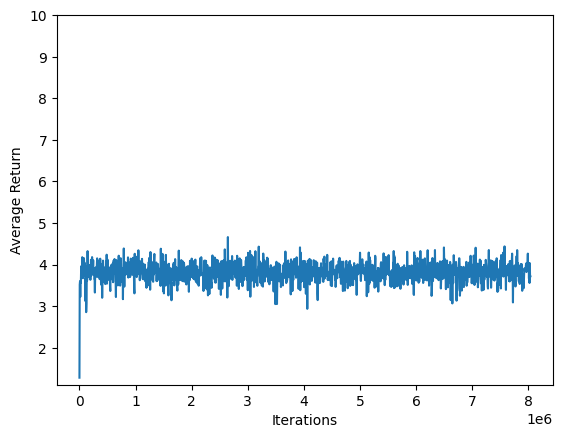

In [15]:
iterations = range(0, train_step_counter + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top = 10)

In [9]:
# test the agent human vs ai
def playHuman():
    policy = agent.policy
    running = True
    env = eval_env
    state = env.reset()
    pygame.init()

    while running:
        to_move = True
        env.render("human")
        mouse = pygame.mouse.get_pos()
        
        if env._envs[0].current_player == 1:
            if 75 + 100 > mouse[0] > 75 and 635 + 100 > mouse[1] > 635:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_r:
                            tile = env._envs[0].tiles[env._envs[0].player_tiles[0][0]]
                            tile.rotate_tile(1)
                            env.render("human")
                    if event.type == pygame.MOUSEBUTTONDOWN:
                        to_move = False
                        state = env.step(0)
                        env.render("human")
                        
            elif 275 + 100 > mouse[0] > 275 and 635 + 100 > mouse[1] > 635:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_r:
                            tile = env._envs[0].tiles[env._envs[0].player_tiles[0][1]]
                            tile.rotate_tile(1)
                            env.render("human")
                    if event.type == pygame.MOUSEBUTTONDOWN:
                        to_move = False
                        state = env.step(4)
                        env.render("human")
                        
            elif 475 + 100 > mouse[0] > 475 and 635 + 100 > mouse[1] > 635:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_r:
                            tile = env._envs[0].tiles[env._envs[0].player_tiles[0][2]]
                            tile.rotate_tile(1)
                            env.render("human")
                    if event.type == pygame.MOUSEBUTTONDOWN:
                        to_move = False
                        state = env.step(8)
                        env.render("human")
                        
        elif env._envs[0].current_player == 2:
            time.sleep(2)
            action_step = policy.action(state)
            env.step(action_step.action)
            env.render("human")
            to_move = False

        elif env._envs[0].current_player == -1 or env._envs[0].game_is_over():
            env.render("human")
            print("Winner: Player " + str(eval_py_env.current_player))
            running = False
                    
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                pygame.quit()
                
def playRandom():
    env = eval_env
    random = random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),env.action_spec())
    policy = agent.policy
    running = True
    state = env.reset()
    pygame.init()
    
    while running:
        to_move = True
        
        if env._envs[0].current_player == 1 and not env._envs[0].game_is_over():
            action_step = random.action(state)
            state = env.step(action_step.action)
            to_move = False
            
        elif env._envs[0].current_player == 2 and not env._envs[0].game_is_over():
            action_step = policy.action(state)
            state = env.step(action_step.action)
            to_move = False

        elif env._envs[0].current_player == -1 or env._envs[0].game_is_over():
            running = False
            pygame.quit()
            return env._envs[0].remaining_players[0]
        
        #uncomment to render
        #env.render("human")
                    
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                pygame.quit()
                
    return 0
        
playHuman()

'''
randomWins = 0
agentWins = 0
for i in range(100000):
    print(i)
    temp = playRandom()
    if temp == 1:
        randomWins += 1
    elif temp == 2:
        agentWins += 1

print("Random Policy Wins: " + str(randomWins))
print("Agent Policy Wins: " + str(agentWins))
'''

'\nrandomWins = 0\nagentWins = 0\nfor i in range(100000):\n    print(i)\n    temp = playRandom()\n    if temp == 1:\n        randomWins += 1\n    elif temp == 2:\n        agentWins += 1\n\nprint("Random Policy Wins: " + str(randomWins))\nprint("Agent Policy Wins: " + str(agentWins))\n'